# Model Tuning

The aim of this phase is to find best parameters for chosen algorithms: RandomForestRegressor and XGBoostRegressor. So far I worked on a sample of data. I will now use whole dataset to tune parametes therefore I would need to preprocess the dataset.

In [1]:
# import libraries
import numpy as np
np.random.seed(2018)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb 
from sklearn.model_selection import validation_curve, GridSearchCV, cross_validate

In [2]:
# set column types to minimize DataFrame
column_types= {'agencyId': 'int16',
 'clouds_all': 'int8',
 'delayInSeconds': 'int64',
 'humidity': 'int8',
 'id': 'int32',
 'pressure': 'int16',
 'routeId': 'int16',
 'stopId': 'int32',
 'stopLat': 'float64',
 'stopLon': 'float64',
 'stopSequence': 'int32',
 'temp': 'float64',
 'tripId': 'int16',
 'vehicleId': 'int32',
 'wind_deg': 'int16',
 'wind_speed': 'int8'}

In [3]:
# create DataFrame 
df = pd.read_csv('train.csv', dtype=column_types, parse_dates=['delayPredictionTimestamp','scheduleTime'])

I will now peprocess whole dataset using code written in preprocessing phase. I will additionaly remove/not merge columns that I decided in model creation phase that are not needed.

In [4]:
# merge stopsintrips file.Merge stopSequence on:'routeId','stopId', 'tripId', merge agency ID on route ID only to have minimal number of missing rows
stops=pd.read_csv('stopsintrips.csv', dtype=column_types)
stops_1=stops[['routeId','agencyId']].drop_duplicates()
df=df.merge(right=stops_1, how='left', on=['routeId'])
df=df.merge(right=stops[['routeId', 'stopId', 'stopSequence', 'tripId']], how='left', on=['routeId','stopId', 'tripId'])
# merge stops file containig location. Not all locations exist in stops file.
location=pd.read_csv('stops.csv', dtype=column_types)
missing_location=df[~df['stopId'].isin(location['stopId'])]['stopId'].unique().reshape(-1,1)
# as there is linear correlation between location and stopID, missing data to be predicted by LinearRegression model
# predict missing stopLat
from sklearn.linear_model import LinearRegression
X=location.iloc[:,:1].values
y=location['stopLat'].values
lr_lat=LinearRegression()
lr_lat.fit(X,y)
# predict missing stopLon
X=location.iloc[:,:1].values
y=location['stopLon'].values
lr_lon=LinearRegression()
lr_lon.fit(X,y)
# add predicted missing locations to location df
missing_lon=lr_lon.predict(missing_location)
missing_lat=lr_lat.predict(missing_location)
missing_loc_df=pd.DataFrame({'stopId':np.squeeze(missing_location), 'stopLat':missing_lat, 'stopLon':missing_lon})
location=pd.concat([location,missing_loc_df],axis=0)
# merge locations with df
df=df.merge(right=location, how='left', left_on=['stopId'], right_on=['stopId'])
# merge weather df. Remove duplicates. Forward fill missing hour rows. Drop columns that do not add value (tested)
weather=pd.read_csv('weatherHistory.csv',sep=';')
weather['dt']=pd.to_datetime(weather['dt'],unit='s')
weather.drop_duplicates(subset='dt', keep='first',inplace=True)
weather=weather.set_index(pd.DatetimeIndex(weather['dt']))
weather=weather.resample('H').ffill()
weather.drop(['dt','dt_iso', 'city_id', 'temp_min', 'temp_max','weather_icon','weather_description','weather_id', 'weather_main', 'pressure', 'clouds_all'], axis=1, inplace=True)
cols=['humidity','wind_speed','wind_deg']
for col in cols: weather[col]=pd.to_numeric(weather[col], downcast='signed')
df['dt']=df['scheduleTime'].dt.round('h')
df=df.merge(right=weather, how='left', left_on='dt', right_index=True)
df.drop(['dt'], axis=1, inplace=True)
# deal with other missing data. AgencyID: fill with most common value '1', stopSequence: fill with median '12'
df['agencyId']=df['agencyId'].fillna(1)
df['stopSequence']=df['stopSequence'].fillna(12)

Now I will add additional features tested in model creaiton phase and create function to exclude 'id' and 'delayInSeconds' from features matrix.

In [5]:
# difference between delayPrediction and schedule time. Wrong date when time close to midnight need to add or subtract 24h
df['time_diff']=(df['delayPredictionTimestamp']-df['scheduleTime']).astype('timedelta64[s]')
df['time_diff']=pd.to_numeric(df['time_diff'], downcast='signed')
df['time_diff']=df['time_diff'].apply(lambda x: x+86400 if x <-50000 else x)
df['time_diff']=df['time_diff'].apply(lambda x: x-86400 if x >50000 else x)
# time features: hour, dayofweek, time- day time in seconds
df['hour'] = df['scheduleTime'].dt.hour
df['dayofweek'] = df['scheduleTime'].dt.dayofweek
df['time']=df['delayPredictionTimestamp'].dt.second+df['delayPredictionTimestamp'].dt.minute*60+df['delayPredictionTimestamp'].dt.hour*3600
# mean delayInSeconds of each agency, routeId, stopID, vehicleId, tripID
agencyMeanDelay = df[ ['agencyId', 'delayInSeconds'] ].groupby(['agencyId']).mean().to_dict()['delayInSeconds']
df['agencyMeanDelay'] = df['agencyId'].map(lambda x: agencyMeanDelay[x])
routeMeanDelay = df[ ['routeId', 'delayInSeconds'] ].groupby(['routeId']).mean().to_dict()['delayInSeconds']
df['routeMeanDelay'] = df['routeId'].map(lambda x: routeMeanDelay[x])
stopIdMeanDelay = df[ ['stopId', 'delayInSeconds'] ].groupby(['stopId']).mean().to_dict()['delayInSeconds']
df['stopIdMeanDelay'] = df['stopId'].map(lambda x: stopIdMeanDelay[x])
vehicleIdMeanDelay = df[ ['vehicleId', 'delayInSeconds'] ].groupby(['vehicleId']).mean().to_dict()['delayInSeconds']
df['vehicleIdMeanDelay'] = df['vehicleId'].map(lambda x: vehicleIdMeanDelay[x])
tripIdMeanDelay = df[ ['tripId', 'delayInSeconds'] ].groupby(['tripId']).mean().to_dict()['delayInSeconds']
df['tripIdMeanDelay'] = df['tripId'].map(lambda x: tripIdMeanDelay[x])

In [6]:
# define features function to exclude some columns from features matrix
def features(df):
    feats = df.columns.values
    black_list = ['id', 'delayInSeconds', 'delayPredictionTimestamp', 'scheduleTime']
    return [feat for feat in feats if feat not in black_list]

Next step is to create features matrix and dependant variable array 

In [7]:
X=df[features].values
y=df['delayInSeconds'].values

I will first check what trees depth gives the best model accuracy. I will use validation curve

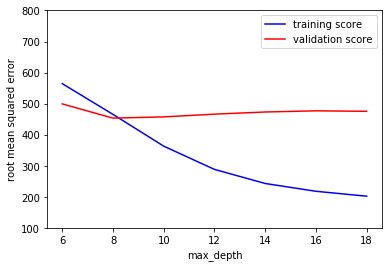

In [8]:
max_depth = [6,8,10,12,14,16,18]
train_score, val_score = validation_curve(RandomForestRegressor(n_estimators=20,random_state=2018,n_jobs=-1),
                                           X, y, 'max_depth', max_depth,  cv=3, scoring= 'neg_mean_squared_error')
plt.plot(max_depth, np.median(np.sqrt(-train_score),axis= 1), color='blue', label='training score')
plt.plot(max_depth, np.median(np.sqrt(-val_score),axis=1), color='red', label='validation score')
plt.legend()
plt.ylim(100, 800)  
plt.xlabel('max_depth')
plt.ylabel('root mean squared error');

It looks like the optimal tree depth is around 8. Deeper trees creates overfitted models as the difference between training and validation score becomes realy big. I will further test models with a depth 8 and a bit more, which can become less overfitted when I add more estimators. I will now use grid search to look for best combination of max_depth, min_samples_leaf and n_estimators.

In [14]:
rf=RandomForestRegressor(n_jobs=-1) 
param_grid = {'max_depth': [8,10,12],  
              'min_samples_leaf': [3,5],  
              'n_estimators': [20,30]} 
grid=GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_squared_error')
grid.fit(X,y)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [8, 10, 12], 'min_samples_leaf': [3, 5], 'n_estimators': [20, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [19]:
import numpy as np
for i in np.arange(12):
    print(grid.cv_results_['params'][i])
    print(np.round(np.sqrt(-grid.cv_results_['mean_test_score'][i]),3))

{'max_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 20}
559.302
{'max_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 30}
555.569
{'max_depth': 8, 'min_samples_leaf': 5, 'n_estimators': 20}
549.354
{'max_depth': 8, 'min_samples_leaf': 5, 'n_estimators': 30}
556.509
{'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 20}
557.467
{'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 30}
560.305
{'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 20}
555.603
{'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 30}
551.687
{'max_depth': 12, 'min_samples_leaf': 3, 'n_estimators': 20}
556.096
{'max_depth': 12, 'min_samples_leaf': 3, 'n_estimators': 30}
556.567
{'max_depth': 12, 'min_samples_leaf': 5, 'n_estimators': 20}
551.939
{'max_depth': 12, 'min_samples_leaf': 5, 'n_estimators': 30}
554.66


In [16]:
print(grid.best_params_) 

{'max_depth': 8, 'min_samples_leaf': 5, 'n_estimators': 20}


I won't present the whole process of grid search but I checked more combiations and finally chose the following parameters:
max_depth=12, min_samples_leaf=5, n_estimators=50. 

Then I tuned parameters of XGBoost in the same way and chose following parameters: max_depth=3, learning_rate=0.1, n_estimators=300

In [17]:
def create_models():   
     return [
        ('rf', RandomForestRegressor(max_depth=12,n_estimators=50, min_samples_leaf=5, random_state=2018, n_jobs=-1)),
        ('xgbr', xgb.XGBRegressor( max_depth=3, learning_rate=0.1, n_estimators=300, n_jobs=-1))]

In [18]:
# compare results
for name, model in create_models():
    scores=cross_validate(model, X, y,cv=3  , scoring='neg_mean_squared_error')
    print ( name + ' test_score:' + str(np.round(np.sqrt(-scores['test_score'].mean()),3)))

rf test_score:552.355
[20:18:29] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[20:25:58] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[20:33:16] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
xgbr test_score:523.565


Finally the best result 523.565 was achieved by XGBoost. It's a significant improvement in comparison to the result obtained using DummyRegressor: 893.053. My final idea is to combine predictions made by XGBmodel with RandomForest ones, as usually combination of predictors create a better predictor. I will check it in prediction phase on the test set.